# General information
 * Author: Joris Busink, Junior Teacher Physics Education.
 * Date: Mon, 31th Okt.
 * About: Data-analysis and data-visualization using Python 3.

 For questions and suggestions please email:<br>
 J.Busink@vu.nl.<br>
 [Github](https://github.com/JBusink/Curve-Fit)

## Structure of the notebook
#### Example 1, Curve_fit:<br>
<a href='#LoadPackages'> 1. Load packages.</a><br>
<a href='#model'> 2. Model and mock data.</a><br>
<a href='#plot'> 3. Plot data.</a><br>
<a href='#fit'> 4. Fit data to model.</a><br>
<a href='#residuals'> 5. Plot residuals.</a><br>
<a href='#chisq'> 6. Calculate (reduced) $\chi^2$.</a><br>
<a href='#confidenceintervals'> 7. Extra: confidence intervals.</a><br>

#### Example 2, Lmfit:<br>
<a href='#lmfit'> 8. Example: Lmfit.</a><br>

# Example: Analysis of a pendulum (SHO)

## Load packages <a id='LoadPackages'></a>
I load the following packages: numpy, matplotlib.pyplot,lmfit and pandas. These pacakges are always useful in doing nummerical calculations using Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import lmfit
import matplotlib.gridspec as gridspec

np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display.

## Pendulum model and mock data<a id='model'></a>
<!-- ![Simple Pendulum](Pendulum_theory_100dpi.png)<br> -->

![Simple Pendulum](https://raw.githubusercontent.com/JBusink/Curve-Fit/main/Figures/Pendulum_theory_100dpi.png?token=GHSAT0AAAAAABZBXVFSUPZBUMNQXYZZXMQWY273PNQ)<br>
A schematic representation of a damped pendulum is shown in the figure above. <br>

We are interested in x-position of the pendulum as a function of time. For abitrary (starting) angle $\theta(t)$ the system has a non-linear response. However, for small angles we can approximate $\sin(\theta(t)) \approx \theta$ and we have a linear system, thus:

\begin{equation}
    x(t) = Ae^{-\gamma t}\sin(\omega t)
    \tag{1}
\end{equation}

The harmonic response is given by $\sin(\omega t)$, with $\omega^2 = \frac{g}{l}$. A is the amplitude of the oscillation. The damping term is modelled by an exponential decay $e^{\gamma t}$, with $\gamma$ a damping constant. <br>

We model this problem using equation 1:

To start of, I create a mock-data set of a damped harmonic oscillator. <br>
The x-data is an array (a <em>'list'</em> that allows nummerical manipulations) that represents the time-domain of the oscillator that ranges from 0 to 10, with $\delta t$ = 0.2. <br>
The y-data is the x-position of the oscillator, we create this by evaluating the Simple Harmonic Oscillator model function using the following input parameters: <br>

\begin{equation}
    x(t) = 2e^{-0.2t}\sin(3t)+0.2\sqrt{t}\zeta(t).
    \tag{2}
\end{equation}

I included a stochastic term, $0.2\sqrt{t}\zeta(t)$, to make our data non-ideal/noisy. $\zeta(t)$ is a random uniform number (float) from -1 to 1. The exact details of the process are not important.

* Line 1: create random seed (to replicate noise).

* Line 3-4: generate t-data and yxdata.

* Line 5-6: noise in t-data and x-data.

In [2]:
np.random.seed(2) #initialize random number generator seed.

t = np.arange(0,10.2,0.2) # t-axis data, an array ('list') from [0,0.2...9.8, 10].
x = 2*np.exp(-0.2*t)*np.sin(3*t) + 0.2*np.sqrt(t)*np.random.uniform(-1,1,len(t)) # x-axis data.
terr = 0.1 # constant error in time.
xerr = 0*t +0.2 # The error in x-position, please note that the shape of xerr must be of the same size as x (by 0*t I enforce this)

## plot the data<a id='plot'></a>

In the next lines of code I plot the data. 
Our data is 2 dimensional (x,y) and contains errors, so we use an errorbar plot. 

* Line 1: create 1 figure (1 row and 1 column). [Figure documentation](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html)

* Line 2: plot data using an errorbarplot. [Errorbar documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html)

* Line 3-8: optional commands.

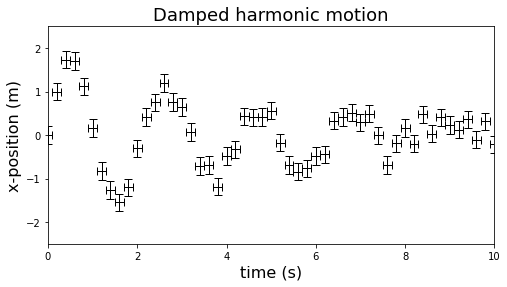

In [3]:
fig, axes = plt.subplots(1,1,figsize=(8,4)) #Creates a single figure with dimensions (12 by 6 (inch))
axes.errorbar(t,x,xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1) #fmt, ecolor and capsize can be personalized.
axes.set_title('Damped harmonic motion', fontsize=18)
axes.set_xlabel('time (s)',fontsize=16)
axes.set_ylabel('x-position (m)',fontsize=16)
axes.set_xlim(np.min(t),np.max(t))
axes.set_ylim(-2.5,2.5)
plt.show()

## Fit data to model<a id='fit'></a>

* Line 1-2: Here we define our model (sinus_model()) using a Python function: a function starts with <em>def</em> and ends with <em>return</em>.<br>
Sinus_model() is our user defined model based on the theory. We vary the time coordinate (the independent variable, t) and the parameters ($x_0$, A, $\omega$ and $\phi$) are determined by a fit.<br> 
Be careful that the independent variable (t) must appear<em> before </em> the parameters, otherwise an error message will appear.<br>

* Line 4: Apply a fit using the curve_fit function. [Curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)<br>

 <em>Curve_fit</em> asks for a minimum of three input arguments: (model, independent variable (time), dependent variable (x-coordinate)), more input arguments are optional.<br> 
In our case, I provide an initial guess of the optimal parameters ($p_0$). Other options include: bounds, weights, method, etc. <br>
Note that providing a good initial guess of $p_0$ and apply parameter bounds significantly reduces the complexity of finding the optimal parameters, if possible, provided them!<br>
<br>
The output of <em>Curve_fit</em> are the optimal parameters <em>popt</em> and the covariance matrix $\mathcal{K_{p_i p_j}}$ <em>pcov</em>, where $\mathcal{K_{p_i p_j}}$ is defined as: <br>

\begin{equation}
    \mathcal{K_{p_i p_j}}= \begin{bmatrix} s_{p_a p_a} & s_{p_b p_a} \\ s_{p_a p_b} & s_{p_b p_b} \end{bmatrix}
    \tag{2}
\end{equation}

For example, $s_{p_a p_a}$ is the (co)variance of parameter a. To obtain the standard deviation $\sigma_{a}$ of parameter a we take the square root of the variance:

\begin{equation}
    \sigma_{a} = \sqrt{s_{p_a p_a}}
    \tag{3}
\end{equation} 

* Line 6-8: Show the optimal fit values and corresponding standard deviations. <br>

* Line 10-15: Make figure, plot the data (black) and the fit (orange).<br>

We plot the fit by making a new dataset, called tfit. We evaluate the the function using the optimal parameters at the values of tfit.

* Line 17-25: Optional commands. <br>

* Line 27-28: Save the figure.<br> 

Note that the figure is saved as a .svg extension. A .svg extension stands for Scalable Vector Image, the image is saved as an object (and not as a collection of pixels). <br>
One can import .svg picture in e.g. inkscape, powerpoint or adobe photoshop to manipulate these, try it!.<br>

The optimal value for  Amplitude (m) is: 2.0380 ± 0.144019
The optimal value for  Gamma (1/s) is: 0.2198 ± 0.023873
The optimal value for  Frequency (rad/s) is: 2.9934 ± 0.022534
The optimal value for  phase (rad) is: -0.0094 ± 0.063073


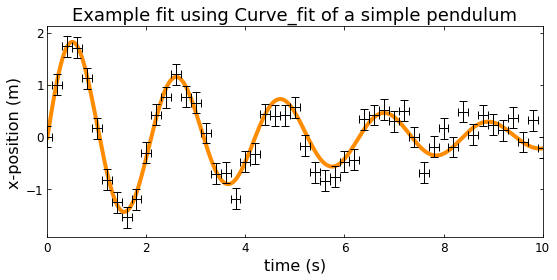

In [4]:
def sinus_model(t,A,gamma,omega,phi):
    return A*np.exp(-gamma*t)*np.sin(omega*t+phi)

popt, pcov = curve_fit(sinus_model,t,x,sigma = xerr,p0=[1,0.1,4.12,0.5])

parameter=['Amplitude (m)','Gamma (1/s)', 'Frequency (rad/s)', 'phase (rad)']
for i in range (4):
    print("The optimal value for ", parameter[i], 'is:', "{:.4f}".format(popt[i]), '\u00B1', "{:.6f}".format(np.sqrt(pcov[i,i])))

tfit = np.linspace(0,max(t),10000) #create new data for fit.

#Plot data + fit        
fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.plot(tfit,sinus_model(tfit,*popt), color ='darkorange', lw = 4,zorder =1) #plot fit
axes.errorbar(t,x,xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1) #fmt, ecolor and capsize can be personalized.

#plot axis labels and limits
axes.set_title('Example fit using Curve_fit of a simple pendulum',fontsize=18)
axes.set_xlabel('time (s)',fontsize=16)
axes.set_ylabel('x-position (m)',fontsize=16)
axes.set_xlim(0,10)

#Some plot settings
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)

# location='Path' #Path to your prefered location, e.g. User/Downloads/
# plt.savefig(location+'simple_pendulum.svg') #Extension can be .png/.jpg/.etc or .svg/.pdf (Vector Image)

plt.show()

## Optional: Residuals <a id='residuals'></a>

In the previous section we fit a model to our data. We observe that the sinusoidal fit captures the data very well.<br>
However, we might also be interested in the limitations of the model. To spot these limitations can be cumbersome,<br> 
to simplify this task, we calculate the difference between the data and the fit: the residuals.<br>
To visualize the residuals I will make an extra figure above the main panel. I use gridspec to create this extra panel.<br>
Using gridspec we can make two (or more) subfigures, a main figure and a sub (residuals) figure.<br>
In the main figure I plot the data and optimal fit. In the residuals plot I plot the difference between the data and the fit, <br>the <em>residuals</em> $r$ of the data:

\begin{equation}
    r = y_{data}-y_{model}.
    \tag{4}
\end{equation}

The residual plot shows valuable information. For example, a systematic pattern in the residuals tells us that our model cannot capture the full data.<br>
In principle, when a systematic pattern  in the residuals is visible, we should modify our model. 

For a more extensive discussion about the meaning of a residual I refer to chapter 4.2 in An Introduction to Error Analysis, by John R. Taylor.

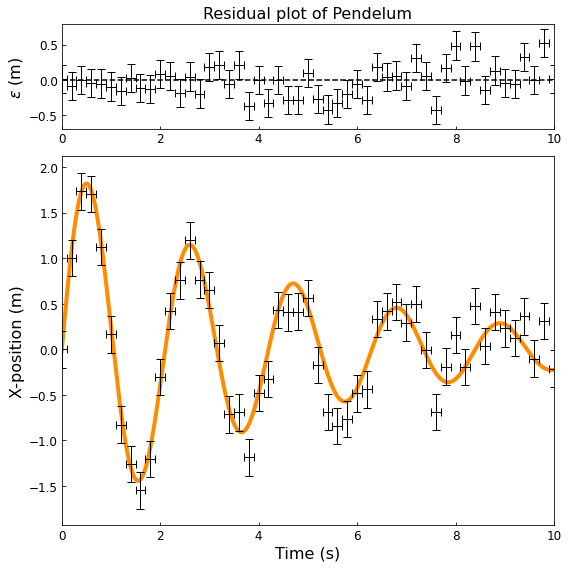

In [6]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:4, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.plot(tfit,sinus_model(tfit,*popt),color='darkorange', lw=4)
axes_main.errorbar(t,x,xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1)

axes_main.set_xlabel('Time (s)',fontsize=16)
axes_main.set_ylabel('X-position (m)',fontsize=16)
axes_main.set_xlim(0,10)
axes_main.tick_params(axis='both',direction ='in',labelsize=12)


axes_residuals.errorbar(t,x-sinus_model(t,*popt),xerr=terr,yerr=xerr,fmt='none',ecolor='black'
                        ,capsize=4,elinewidth=1)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(0,10)

plt.tight_layout()
plt.show()

## reduced $\chi^2$ <a id='chisq'></a>

In the previous figure we observed that our fit captures the data nicely. In the residuals we observe that after t $\approx$ 7 s,<br>
the noise starts to dominate. We quantify the deviation between the observed and expected data using a $\chi^2$ analysis: <br>

\begin{equation}
    \chi^2 = \sum_{1}^{N}\frac{(y_i-f(x_i))^2}{\sigma_i^2}=\sum_{1}^{N}\frac{r_i^2}{\sigma_i^2}. 
    \tag{5}
\end{equation}

$\sigma_{i}$ is the standard deviation 'error' on the observed datapoint $y_i$. 
Lastly, we should correct for the number of <em>degrees of freedom</em>. <br>
We have N data points and c parameters, so we have d = N - c <em>degrees of freedom</em>.<br> 
We define the following:

\begin{equation}
    \tilde{\chi}^2 =\frac{\chi^2}{d},
    \tag{6}
\end{equation}

$\tilde{\chi}^2$ is the reduced $\chi^2$, where we included the effect of the degrees of freedom. The value of $\tilde{\chi}^2$ is a measure of the deviation<br> 
between the data and the model.<br>

For a more general discussion about the significance and applicability of $\tilde{\chi}^2$ I refer to chapter 12 in An Introduction to Error Analysis by John R. Taylor.

In [7]:
chisq = np.sum(((x-sinus_model(t,*popt))/xerr)**2)
d = len(x) - len(popt)
red_chisq = chisq/d
print("chi-squared = %.4f" % chisq)
print("df = %d" % d)
print("Reduced chi-squared = %.4f" % red_chisq)

chi-squared = 60.3651
df = 47
Reduced chi-squared = 1.2844


##  Optional: Confidence Intervals <a id='confidenceintervals'></a>

In the previous sections we calculated the optimal parameters, the errors on the optimal parameters and the $\tilde{\chi}^2$ value.<br>
Our model consists of 4 parameters and the error on the optimal parameter:<br>

* The optimal value for  $A$ (m) is: 2.0137 ± 0.045014
* The optimal value for  $\gamma$ (1/s) is: 0.2087 ± 0.011162
* The optimal value for  $\omega$ (rad/s) is: 2.9943 ± 0.010095
* The optimal value for  $\phi$ (rad) is: 0.0010 ± 0.018336

Now we can ask ourself the question: how likely is it that my datapoint falls within n-standard deviations of my curve.<br>

We answer this question by constructing confidence intervals (C.I.) around the optimal fit. 

The C.I. is defined as, 
\begin{align*}
    Pr(\mu-1\sigma\le X \le \mu +1\sigma)\approx 68.27 \%, \\
    Pr(\mu-3\sigma\le X \le \mu +3\sigma)\approx 99.73 \%, \\
    Pr(\mu-n\sigma \le X \le \mu + n\sigma ) = erf(x/\sqrt{2}).\\
\end{align*}
The C.I. tells us how likely it is that our observation $X$ is found within the interval,<br> 
with $\mu$ the mean of the distribution $X$ and $\sigma$ the standard deviation of the distribution $X$.

We have 4 parameters, each with it's own deviation, constructing the C.I. is not trivial.<br>
For example, a (positive) deviation (from the mean) of the Amplitude can be mitigated by a (positive) deviation<br>
of the damping $\gamma$ term. 

However, the overall effect is a mean all parameters, we cannot simply add each individual contribution. <br>
To calculate the mean response and the C.I. we use a Monte-Carlo technique.<br>
We use repeated Gaussian sampling of the parameters to obtain a statistical mean response (the optimal fit)<br>
and we calculate the C.I. by the standard deviation of the mean response.

Line 4-7: Random sampling around the optimal parameters.

Line 8-11: Evaluate the model response of the random parameters 'ydata_random'. Thus, ydata_random contains 1000 curves.<br> 
Each curve has a (random) unique set of parameters around the optimal value. The mean of ydata_random is the optimal fit.<br>
The standard deviation (at each data point) of ydata_random is $\sigma$, this is the boundary of the C.I.  

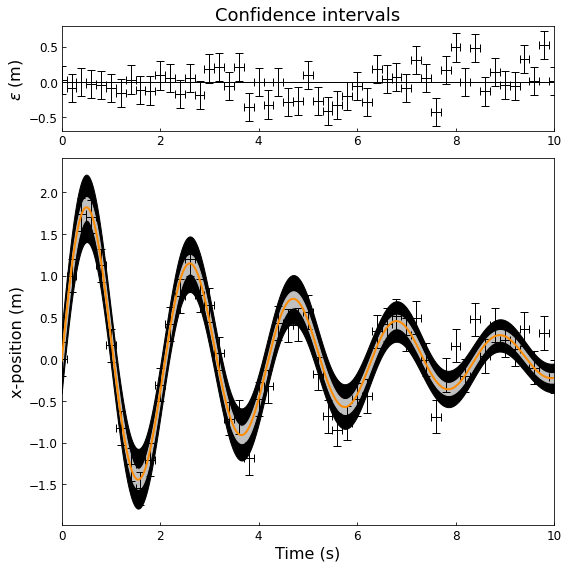

In [8]:
from cgitb import reset
import matplotlib.gridspec as gridspec
import scipy.stats as st

popt0 = popt[0]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[0]
popt1 = popt[1]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[1]
popt2 = popt[2]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[2]
popt3 = popt[3]+np.random.normal(0,1,size=1000)*np.sqrt(np.diag(pcov))[3]
ylist =[]
for i in range(0,1000,1):
    ydata_random = sinus_model(tfit,popt0[i],popt1[i],popt2[i],popt3[i])
    ylist.append(ydata_random)
    
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(4, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:4, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.errorbar(t,x,xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1, marker = 's',zorder=5) #fmt, ecolor and capsize can be personalized.
axes_main.plot(tfit,sinus_model(tfit,*popt),color='darkorange',ls='-', lw=2,zorder =5)

axes_main.fill_between(tfit,np.mean(ylist,axis=0)+3*np.std(ylist,axis=0),np.mean(ylist,axis=0)-3*np.std(ylist,axis=0),color='black')
axes_main.fill_between(tfit,np.mean(ylist,axis=0)+1*np.std(ylist,axis=0),np.mean(ylist,axis=0)-1*np.std(ylist,axis=0),color='silver')
axes_main.set_xlabel('Time (s)',fontsize=16)
axes_main.set_ylabel('x-position (m)',fontsize=16)
axes_main.set_xlim(0,10)

axes_residuals.errorbar(t,x-sinus_model(t,*popt),xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1) #fmt, ecolor and capsize can be personalized.
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='-',lw=1)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Confidence intervals',fontsize=18)
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(0,10)

plt.tight_layout()
plt.show()


# Example: fit data using lmfit <a id='lmfit'></a>

We can also use a package called 'lmfit' to fit our data to a model. On the canvas page there is an extensive document<br>
that guides you through the process of fitting using lmfit, for questions please visit the canvas page.<br>


In the code below you find a minimum working example using lmfit:<br>

* Line 4: define model using $\lambda$ function.

* Line 7: Initialize model parameters system parameters $(p_0)$.

* Line 10: Provide bound to e.g. amplitude parameter.

 * Line 13: Apply fit.


In [9]:
from lmfit import models

#Define model:
model = models.Model(lambda t, Amplitude, Gamma, Omega,Phi: Amplitude * np.exp(-Gamma * t) * np.sin(Omega*t+Phi))

#Initialize parameters (p0)
params = model.make_params(Amplitude=2, Gamma=0.2, Omega=3,Phi=2)

#Provide bounds
params['Amplitude'].min = 0

#Fit data using model.fit
fit = model.fit(x, t=t, params=params,weights = 1/xerr)

We can show the fit using f.best_fit and show the fit statistics using fit.fit_report().
The fit_report() provides the optimal parameters, the error on each parameter and the $\tilde{\chi^2}$. 

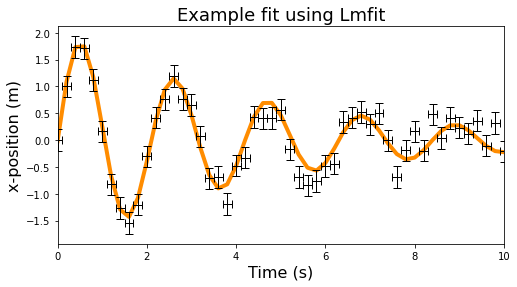

[[Model]]
    Model(<lambda>)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 47
    # data points      = 51
    # variables        = 4
    chi-square         = 60.3650853
    reduced chi-square = 1.28436352
    Akaike info crit   = 16.5978476
    Bayesian info crit = 24.3251501
[[Variables]]
    Amplitude:  2.03801448 +/- 0.14402310 (7.07%) (init = 2)
    Gamma:      0.21976245 +/- 0.02387387 (10.86%) (init = 0.2)
    Omega:      2.99336618 +/- 0.02253559 (0.75%) (init = 3)
    Phi:       -0.00941352 +/- 0.06307191 (670.01%) (init = 2)
[[Correlations]] (unreported correlations are < 0.100)
    C(Amplitude, Gamma) = 0.744
    C(Omega, Phi)       = -0.701
    C(Amplitude, Phi)   = -0.128


In [10]:
fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.plot(t, fit.best_fit, color='darkorange',lw=4,zorder =1)#plot fit
axes.errorbar(t,x,xerr=terr,yerr=xerr,fmt='none',ecolor='black',capsize=4,elinewidth=1) 

#plot axis labels and limits
axes.set_title('Example fit using Lmfit',fontsize=18)
axes.set_xlabel('Time (s)',fontsize=16)
axes.set_ylabel('x-position (m)',fontsize=16)
axes.set_xlim(0,10)
plt.show()

#print fit report
print(fit.fit_report())

# Your Experiment starts here

* Author: Student name.
* Date: Date.
* About: Your experiment.<br>
* TA: 

Please ask your TA if you need to hand in your code at the end of the practical course.